In [1]:
import sys
print(f"Python version: {sys.version}")


Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [2]:
from nilearn.maskers import MultiNiftiLabelsMasker, NiftiLabelsMasker

# Script to check quality of the data
Includes Timeseries heatmaps, atlas fitting, report saving, GLM building
Support script : ../func.py

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from nilearn.plotting import plot_stat_map
#import datalad.api as dl
import warnings
import nibabel as nib
warnings.simplefilter('ignore')

#### Load data

In [4]:
nsub = 3

data_dir = '/data/rainville/Hypnosis_ISC/4D_data/full_run'

ana_run = glob.glob(os.path.join(data_dir, 'sub*', '*analgesia*.nii.gz'))[0:nsub]
hyper_run = glob.glob(os.path.join(data_dir, 'sub*', '*hyperalgesia*.nii.gz'))[0:nsub]

subjects = [os.path.basename(os.path.dirname(path)) for path in ana_run][0:nsub]
project_dir = '/data/rainville/dSutterlin/projects/isc_suggestions'
save_dir = os.path.join(project_dir, 'results')
behav_path = r"/data/rainville/dSutterlin/projects/resting_hypnosis/resting_state_hypnosis/atlases/Hypnosis_variables_20190114_pr_jc.xlsx"
APM_subjects = ['APM' + sub[4:] for sub in subjects][0:nsub] # make APMXX format instead of subXX


In [5]:

ana_run
hyper_run

['/data/rainville/Hypnosis_ISC/4D_data/full_run/sub-38/sub-38_hyperalgesia_run-02_bold_4D.nii.gz',
 '/data/rainville/Hypnosis_ISC/4D_data/full_run/sub-07/sub-07_hyperalgesia_run-02_bold_4D.nii.gz',
 '/data/rainville/Hypnosis_ISC/4D_data/full_run/sub-42/sub-42_hyperalgesia_run-01_bold_4D.nii.gz']

Load data

#### **Probabilistic atlas**

(array([ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
        5.        ,  6.00000001,  6.99999999,  8.        ,  9.        ,
       10.        , 11.        , 12.        , 13.        , 14.        ,
       15.        , 16.        , 17.        , 18.00000001, 18.99999999,
       20.        , 21.        , 22.        , 23.        , 24.        ,
       25.        , 26.        , 27.        , 28.        , 29.        ,
       30.        , 31.00000001, 31.99999999, 33.        , 34.        ,
       35.        , 36.        , 37.        , 38.        , 39.        ,
       40.        , 41.        , 42.        , 43.00000001, 43.99999999,
       45.        , 46.        , 47.        , 48.        , 49.        ,
       49.99999999]), array([751102,   1746,   2929,   6376,   2952,   2786,   3383,   4862,
         2622,   4809,   1988,   3130,   2629,   1870,   2432,  11709,
         3343,   4017,   2275,   1095,   4350,   3187,   1743,   1250,
         5359,   5557,   5411,   1667,   221

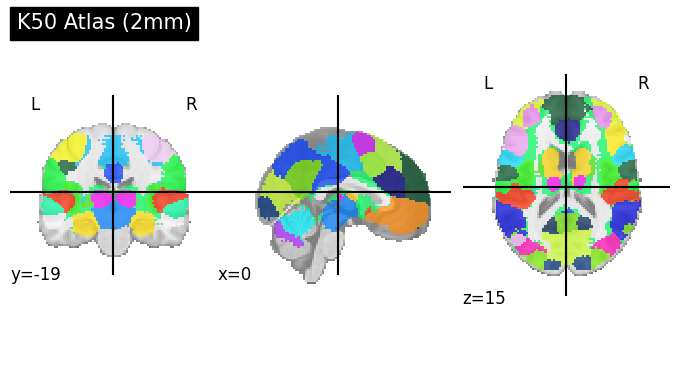

In [6]:
from nilearn.image import load_img
from nilearn.plotting import plot_roi

atlas_path = os.path.join(project_dir, 'masks', 'k50_2mm.nii/', '*.nii')
mask_nifti = load_img(atlas_path)
plot_roi(mask_nifti, title="K50 Atlas (2mm)")
print(np.unique(mask_nifti.get_fdata(), return_counts=True))

##### DiFuMo64

In [8]:
atlas_path = '/data/rainville/dSutterlin/projects/isc_suggestions/DiFuMo256/3mm/maps.nii.gz'
atlas_dict_path = '/data/rainville/dSutterlin/projects/isc_suggestions/DiFuMo256/labels_256_dictionary.csv'
atlas = nib.load(atlas_path)
atlas_df = pd.read_csv(atlas_dict_path)
print('atlas loaded with N ROI : ', atlas.shape)

atlas loaded with N ROI :  (104, 123, 104, 256)


## Apply parcellation and plot reports
1) group
2) individual report + ROI x TRs heatmaps

In [9]:
mask_nifti.shape

(91, 109, 91, 1)

#### 1) Group masker fitting on atlas

#### Function to fit atlas to data for all subjects, and generate group report

In [19]:
import os
from nilearn.maskers import MultiNiftiLabelsMasker

def generate_multinifti_report(func_list, mask_nifti, project_dir, condition_name="Analgesia"):
    """
    Generate and save a MultiNiftiLabelsMasker report for a given condition.

    Parameters
    ----------
    func_list : list of str
        List of paths to the functional files for the condition.
    mask_nifti : str
        Path to the 4D mask NIfTI file.
    project_dir : str
        Path to the project directory where results will be saved.
    condition_name : str, optional
        Name of the condition (default is "Analgesia").
        This name will be used in folder and report names.

    Returns
    -------
    None
    """
    # Ensure mask_nifti is a valid 4D mask
    assert len(mask_nifti.shape) == 4, "Mask image must be 3D."

    nsub = len(func_list)
    
    # Initialize MultiNiftiLabelsMasker
    multi_masker = MultiNiftiLabelsMasker(mask_nifti, standardize=True, detrend=True)

    # Fit-transform the functional files
    multi_fit = multi_masker.fit_transform(func_list)

    # Create directory for reports
    report_dir = os.path.join(project_dir, 'results/imaging', f'reports_{condition_name}_MultiNiftiLabels_ROI')
    os.makedirs(report_dir, exist_ok=True)

    # Generate and save the report
    report = multi_masker.generate_report()
    report_name = f'MultiLabels_report_{condition_name}_{nsub}-subjects.html'
    report_path = os.path.join(report_dir, report_name)
    report.save_as_html(report_path)

    print(f"Report saved at: {report_path}")


#### Apply group label masker and generate report

In [36]:
generate_multinifti_report(ana_run, mask_nifti, project_dir, condition_name="Analgesia")
generate_multinifti_report(hyper_run, mask_nifti, project_dir, condition_name="Hyperalgesia")


Report saved at: /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/reports_Analgesia_MultiNiftiLabels_ROI/MultiLabels_report_Analgesia.html
Report saved at: /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/reports_Hyperalgesia_MultiNiftiLabels_ROI/MultiLabels_report_Hyperalgesia.html


#### 2) Individual atlas report (label masker)
-->Save ROI x TRs heatmap + individual LabelMasker report in /results/cond/

#### Function to generate individual report and heatmaps of ROI x TRs for each subject. Saves in /results/imaging/

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.maskers import NiftiLabelsMasker

def generate_individual_labelMasker_reports_heatmap(subjects, func_list, mask_nifti, project_dir, condition_name="Analgesia"):
    """
    Generate and save individual ROI reports and heatmaps for each subject.

    Parameters
    ----------
    func_list : list of str
        List of paths to the functional files for each subject.
    mask_nifti : str
        Path to the 4D mask NIfTI file.
    project_dir : str
        Path to the project directory where results will be saved.
    condition_name : str, optional
        Name of the condition (default is "Analgesia").
        This name will be used in folder and report/heatmap names.

    Returns
    -------
    list of numpy.ndarray
        List of masked timeseries for all subjects.
    """
    # Directory to save individual reports
    report_dir = os.path.join(project_dir, 'results/imaging', f'ROI_reports_{condition_name}')
    os.makedirs(report_dir, exist_ok=True)

    # Initialize NiftiLabelsMasker
    label_masker = NiftiLabelsMasker(mask_nifti, standardize=True, detrend=True)
    print(f"------{condition_name}-----")
    print(f"Masker initialized with {label_masker} mask")

    # Storage for masked timeseries
    fitted_masker = []
    masked_timeseries = []

    for i, file in enumerate(func_list):
        sub_id = subjects[i]
        print(f"Processing subject {sub_id}...")
        
        # Extract timeseries for the subject
        fit_masker = label_masker.fit(file)
        fitted_masker.append(fit_masker)
        ts = label_masker.transform(file)
        masked_timeseries.append(ts)
        #fit_mask_path = os.path.join(report_dir, f'fitted_masker_{sub_id}_{condition_name}.pkl')
        
        # Generate and save the report for this subject
        report = label_masker.generate_report()
        report_path = os.path.join(report_dir, f'ROI_report_{sub_id}_{condition_name}.html')
        report.save_as_html(report_path)

        # Plot heatmap of ROI × TRs
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.heatmap(ts.T, cmap='coolwarm', cbar=True, ax=ax)
        ax.set_title(f"Subject {i + 1} - Time Series of All ROIs ({condition_name})", fontsize=16)
        ax.set_xlabel('Timepoints', fontsize=12)
        ax.set_ylabel('ROI Index', fontsize=12)
        plt.tight_layout()

        # Save the heatmap
        heatmap_path = os.path.join(report_dir, f'ROI_heatmap_{sub_id}_{condition_name}.png')
        plt.savefig(heatmap_path, dpi=300)
        plt.close()


        print(f"Heatmap saved for {sub_id} at {heatmap_path}")
        print(f"Report saved for {sub_id} at {report_path}")
        #print(f'saved fitted masker for {sub_id} as {fit_mask_path}')

    return masked_timeseries, fitted_masker


#### Generate and save individual report and heatmaps for two runs

In [11]:
ana_masked_timeseries, fitted_mask_ana = generate_individual_labelMasker_reports_heatmap(subjects, ana_run, mask_nifti, project_dir, condition_name="Analgesia")

hyper_masked_timeseries, fitted_mask_hyper = generate_individual_labelMasker_reports_heatmap(subjects, hyper_run, mask_nifti, project_dir, condition_name="Hyperalgesia")



Processing subject sub-38...
Heatmap saved for sub-38 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Analgesia/ROI_heatmap_sub-38_Analgesia.png
Report saved for sub-38 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Analgesia/ROI_report_sub-38_Analgesia.html
Processing subject sub-07...
Heatmap saved for sub-07 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Analgesia/ROI_heatmap_sub-07_Analgesia.png
Report saved for sub-07 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Analgesia/ROI_report_sub-07_Analgesia.html
Processing subject sub-42...
Heatmap saved for sub-42 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Analgesia/ROI_heatmap_sub-42_Analgesia.png
Report saved for sub-42 at /data/rainville/dSutterlin/projects/isc_suggestions/results/imaging/ROI_reports_Analgesia/ROI_report_sub-42_Analgesia.html
Processing

### Save masked timeseries and fitted masker

In [6]:
results_dir = os.path.join(project_dir, 'results/imaging')
ana_ts_dict = {sub : ts for sub, ts in zip(subjects, ana_masked_timeseries)}
hyper_ts_dict = {sub : ts for sub, ts in zip(subjects, hyper_masked_timeseries)}

ana_filename = os.path.join(results_dir, 'firstLevel/ana_masked_{}sub.npz'.format(len(subjects)))
hyper_filename = os.path.join(results_dir, 'firstLevel/hyper_masked_{}sub.npz'.format(len(subjects)))

np.savez_compressed(ana_filename, **ana_ts_dict)
np.savez_compressed(hyper_filename, **hyper_ts_dict)

print(f"Saved ANA timeseries to: {ana_filename}")
print(f"Saved HYPER timeseries to: {hyper_filename}")

ana_fitted_mask_path = os.path.join(results_dir, 'firstLevel/ana_fitted_maskers_{}-subjects.pkl'.format(len(subjects)))
hyper_fitted_mask_path = os.path.join(results_dir, 'firstLevel/hyper_fitted_maskers_{}-subjects.pkl'.format(len(subjects)))

with open(ana_fitted_mask_path, 'wb') as f:
    pkl.dump(fitted_mask_ana, f)

with open(hyper_fitted_mask_path, 'wb') as f:
    pkl.dump(fitted_mask_hyper, f)

print(f"Saved ANA fitted maskers to: {ana_fitted_mask_path}")
print(f"Saved HYPER fitted maskers to: {hyper_fitted_mask_path}")


NameError: name 'ana_masked_timeseries' is not defined

# GLM and data structure

#### Test SPM mat

In [88]:
ls /data/rainville/Hypnosis_ISC/4D_data/sub-06


ls: cannot access '/data/rainville/Hypnosis_ISC/4D_data/sub-06': No such file or directory


#### Import and load data!

In [24]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

parent_dir = os.path.abspath(os.path.join(os.path.dirname('func.py'), ".."))
sys.path.append(parent_dir)

In [25]:
nsub = 3

data_dir = '/data/rainville/Hypnosis_ISC/4D_data/full_run'

ana_run = glob.glob(os.path.join(data_dir, 'sub*', '*analgesia*.nii.gz'))[0:nsub]
hyper_run = glob.glob(os.path.join(data_dir, 'sub*', '*hyperalgesia*.nii.gz'))[0:nsub]

subjects = [os.path.basename(os.path.dirname(path)) for path in ana_run][0:nsub]
project_dir = '/data/rainville/dSutterlin/projects/isc_suggestions'
behav_path = r"/data/rainville/dSutterlin/projects/resting_hypnosis/resting_state_hypnosis/atlases/Hypnosis_variables_20190114_pr_jc.xlsx"
APM_subjects = ['APM' + sub[4:] for sub in subjects][0:nsub] # make APMXX format instead of subXX
APM_subjects

['APM38', 'APM07', 'APM42']

#### Extract timestamps/events, movement files based on APM_subjects

In [26]:
import func
import importlib
importlib.reload(func) 

conditions = ['Analgesia', 'Hyperalgesia']
events_dir = '/data/rainville/HYPNOSIS_IMAGING_DATA/timestamps'
confound_dir = '/data/rainville/HYPNOSIS_IMAGING_DATA/Nii'


events_ana =[func.get_timestamps(
                    data_dir, sub, events_dir, conditions[0], return_path=False
                )
              .sort_values(by='onset')
                for sub in APM_subjects
          ]
events_ana_dct = {sub : 
                    func.get_timestamps(
                    data_dir, sub, events_dir, conditions[0], return_path=False
                )
               .sort_values(by='onset')
                    for sub in APM_subjects
                   }
# prefered dict but less easy to index
events_hyper =[func.get_timestamps(
                    data_dir, sub, events_dir, conditions[1], return_path=False
                )
               .sort_values(by='onset')
                for sub in APM_subjects
          ]
events_hyper_dct = {sub : 
                    func.get_timestamps(
                    data_dir, sub, events_dir, conditions[1], return_path=False
                )
               .sort_values(by='onset')
                    for sub in APM_subjects
                   }

#ANA run first!
confound_files=[]
for sub in APM_subjects:
    
    formatted_sub = f"{sub[:3]}_{sub[3:]}*"
    #print(formatted_sub)
    # Extend the confound_files list with the matching files
    confound_files.extend(
        glob.glob(os.path.join(confound_dir, 'H*', '*', formatted_sub, '*_8nuisreg_*'))
    )
    #print(glob.glob(os.path.join(confound_dir, 'H*', '*', formatted_sub, '*_8nuisreg_*')))
print('len confound files : ', len(confound_files))    

cf4 = []  #extra 4 sub with diff TRs in H2/APM*/*nuis.txt
for sub in APM_subjects:
    formatted_sub = f"{sub[:3]}_{sub[3:]}*"
    cf4.extend(
        glob.glob(os.path.join(confound_dir, 'H*', formatted_sub, '*_8nuisreg_*'))
    )
    
print(f'found extra {len(cf4)} condound files')
confound_files.extend(cf4)

# Reorder matching APM_subjects
ordered_confound_files = []
for sub in APM_subjects:
    formatted_sub = f"{sub[:3]}_{sub[3:]}"
    match = [f for f in confound_files if formatted_sub in f]
    if match:
        ordered_confound_files.append(match[0])  # Take the first match

confound_files = ordered_confound_files
confound_files_dct = {sub : file for sub, file in zip(subjects, confound_files)}
print('Total confound files : ', len(confound_files))


len confound files :  3
found extra 0 condound files
Total confound files :  3


Ensure same length and order of all variables

In [27]:
# Split movement regressor file in two according to scan number of each 
# output loaded np arrays fir each run
ana_confounds = []
hyper_confounds = []
for i, sub in enumerate(subjects):
    
    conf_path = confound_files[i]
    confounds = np.array(pd.read_csv(conf_path, sep= '\s+', header=None))

    print(confounds.shape, type(confounds), 'len % 2 :', len(confounds)/2)
    
    ana_data = ana_ts_dict[sub]
    nscan_ana = ana_data.shape[0]
    up_ana = confounds[0:nscan_ana, :]

    hyper_data = hyper_ts_dict[sub]
    nscan_hyper = hyper_data.shape[0]
    low_hyper = confounds[nscan_ana: nscan_ana+nscan_hyper ,:]
    
    print("low_ana shape:", up_ana.shape)
    print("low_hyper shape:", low_hyper.shape)

    ana_confounds.append(up_ana)
    hyper_confounds.append(low_hyper)
    
    #up, low = split_conf_matrix(confound_files[i], nscan, run_names[i]
    #    )

(754, 8) <class 'numpy.ndarray'> len % 2 : 377.0
low_ana shape: (377, 8)
low_hyper shape: (377, 8)
(744, 8) <class 'numpy.ndarray'> len % 2 : 372.0
low_ana shape: (372, 8)
low_hyper shape: (372, 8)
(754, 8) <class 'numpy.ndarray'> len % 2 : 377.0
low_ana shape: (377, 8)
low_hyper shape: (377, 8)


relevant variables computed so far

events_ana
events_hyper

ana_confounds
hyper_confounds

ana_filename
hyper_filename

ana_ts_dict
hyper_ts_dict



In [28]:
print(len(APM_subjects), len(events_hyper), len(events_ana), len(confound_files))
confound_files

3 3 3 3


['/data/rainville/HYPNOSIS_IMAGING_DATA/Nii/H1/377vol/APM_38_H1/APM38_8nuisreg_concat.txt',
 '/data/rainville/HYPNOSIS_IMAGING_DATA/Nii/H1/372vol/APM_07_H1/APM07_8nuisreg_concat.txt',
 '/data/rainville/HYPNOSIS_IMAGING_DATA/Nii/H2/377vol/APM_42_H2/APM42_8nuisreg_concat.txt']

### Check TRs per condition

#### Function to count TRs for suggestion conditions, for neutral and modulation suggestion. Added to func.py file

In [29]:
import matplotlib.patches as mpatches

def count_TRs_2conds_general(
    event_files, 
    TR=3, 
    neutral_pattern="N_ANA.*instrbk", 
    modulation_pattern=r"ANA.*instrbk", 
    title='Neutral and Modulation Suggestion TRs per Subjects',
    neutral_color="skyblue",
    modulation_color="salmon",
    save_path=False
):
    """
    Counts and compares the total number of TRs for neutral and modulation suggestion blocks across subjects,
    with shading based on individual block durations.

    Parameters
    ----------
    event_files : list of pandas.DataFrame
        A list where each element is a DataFrame containing the event file data for one subject.
        Each DataFrame must have columns: 'onset', 'duration', 'trial_type'.

    TR : int, optional
        The TR (Repetition Time) duration in seconds. Default is 3.

    neutral_pattern : str, optional
        Regex pattern to identify neutral suggestion blocks. Default is "N_ANA.*instrbk".

    modulation_pattern : str, optional
        Regex pattern to identify modulation suggestion blocks. Default is "ANA.*instrbk".

    title : str, optional
        The title for the plot. Default is 'Neutral and Modulation Suggestion TRs per Subjects'.

    Returns
    -------
    pd.DataFrame
        A DataFrame summarizing the total TRs for neutral and modulation suggestion blocks for all subjects.

    Notes
    -----
    Neutral and modulation suggestion blocks are identified using provided regex patterns,
    and each bar is shaded based on the individual block durations.
    """
    # Initialize lists to store TR counts for each condition
    neutral_TRs_list = []
    modulation_TRs_list = []

    # Initialize storage for block details for shading
    neutral_block_details = []
    modulation_block_details = []

    # Loop through all subjects' event data
    for i, events in enumerate(event_files):
        # Filter for neutral suggestion blocks
        neutral_blocks = events[events['trial_type'].str.contains(neutral_pattern, na=False, regex=True)]
        neutral_durations = neutral_blocks['duration'].tolist()
        neutral_total_duration = sum(neutral_durations)
        neutral_total_TRs = int(neutral_total_duration / TR)
        neutral_TRs_list.append(neutral_total_TRs)
        neutral_block_details.append([(d / TR) for d in neutral_durations])

        # Filter for modulation suggestion blocks, excluding the neutral ones
        modulation_blocks = events[
            events['trial_type'].str.contains(modulation_pattern, na=False, regex=True) &
            ~events['trial_type'].str.contains(neutral_pattern, na=False, regex=True)
        ]
        modulation_durations = modulation_blocks['duration'].tolist()
        modulation_total_duration = sum(modulation_durations)
        modulation_total_TRs = int(modulation_total_duration / TR)
        modulation_TRs_list.append(modulation_total_TRs)
        modulation_block_details.append([(d / TR) for d in modulation_durations])

    # Create a DataFrame for easier comparison
    TRs_df = pd.DataFrame({
        "Subject": [f"Subject_{i+1}" for i in range(len(event_files))],
        "Neutral_TRs": neutral_TRs_list,
        "Modulation_TRs": modulation_TRs_list
    })

    print(TRs_df)

    # Check for discrepancies in TR counts
    if TRs_df["Neutral_TRs"].nunique() == 1 and TRs_df["Modulation_TRs"].nunique() == 1:
        print("All subjects have the same number of TRs for both conditions.")
    else:
        print("Discrepancies found in the number of TRs across subjects.")

    # Plot the results with shading
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.4
    x_positions = np.arange(len(TRs_df))

    # Plot neutral and modulation TRs with shading
    for i, x in enumerate(x_positions):
        # Neutral blocks
        bottom = 0
        for block_TRs in neutral_block_details[i]:
            ax.bar(x - bar_width / 2, block_TRs, width=bar_width, color=neutral_color, bottom=bottom, edgecolor="black", alpha=0.8)
            bottom += block_TRs

        # Modulation blocks
        bottom = 0
        for block_TRs in modulation_block_details[i]:
            ax.bar(x + bar_width / 2, block_TRs, width=bar_width, color=modulation_color, bottom=bottom, edgecolor="black", alpha=0.8)
            bottom += block_TRs

    # Add labels, title
    ax.set_xlabel("Subjects", fontsize=14)
    ax.set_ylabel("Total TRs", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(TRs_df["Subject"], rotation=45, fontsize=10)

    # Create a manual legend with distinct colors
    neutral_patch = mpatches.Patch(color=neutral_color, label="Neutral TRs")
    modulation_patch = mpatches.Patch(color=modulation_color, label="Modulation TRs")
    ax.legend(handles=[neutral_patch, modulation_patch], fontsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()
    plt.close()

    return TRs_df, fig


#### Number of TRs (total condition duration / TR) TR=3 in this dataset

     Subject  Neutral_TRs  Modulation_TRs
0  Subject_1          102              79
1  Subject_2          102              79
2  Subject_3          102              79
All subjects have the same number of TRs for both conditions.


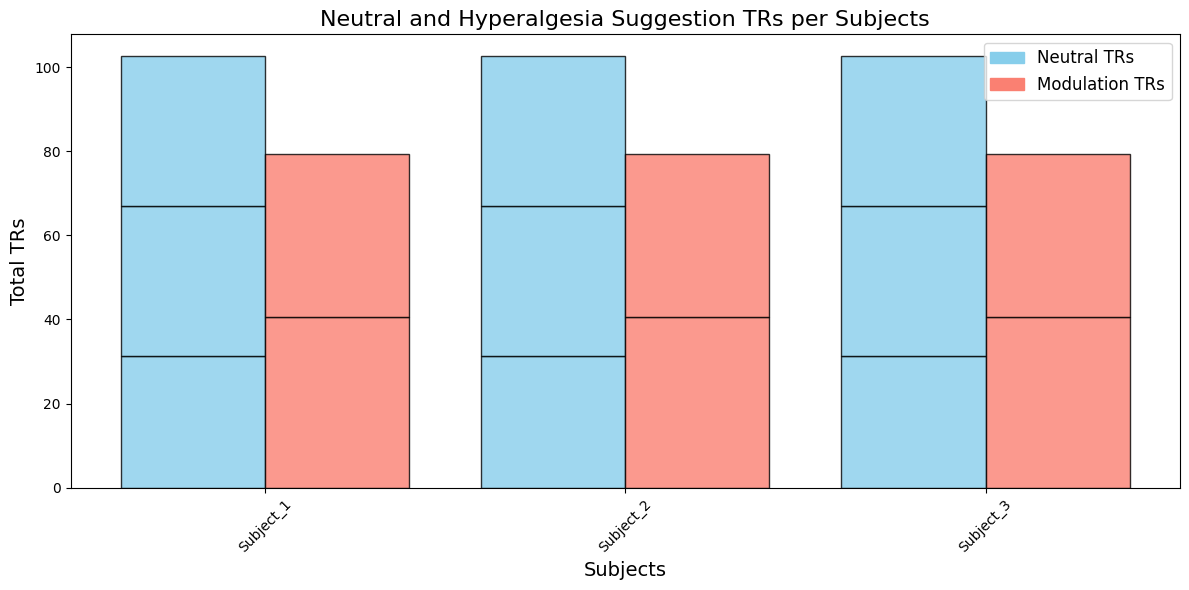

     Subject  Neutral_TRs  Modulation_TRs
0  Subject_1          102              82
1  Subject_2          102              82
2  Subject_3          102              82
All subjects have the same number of TRs for both conditions.


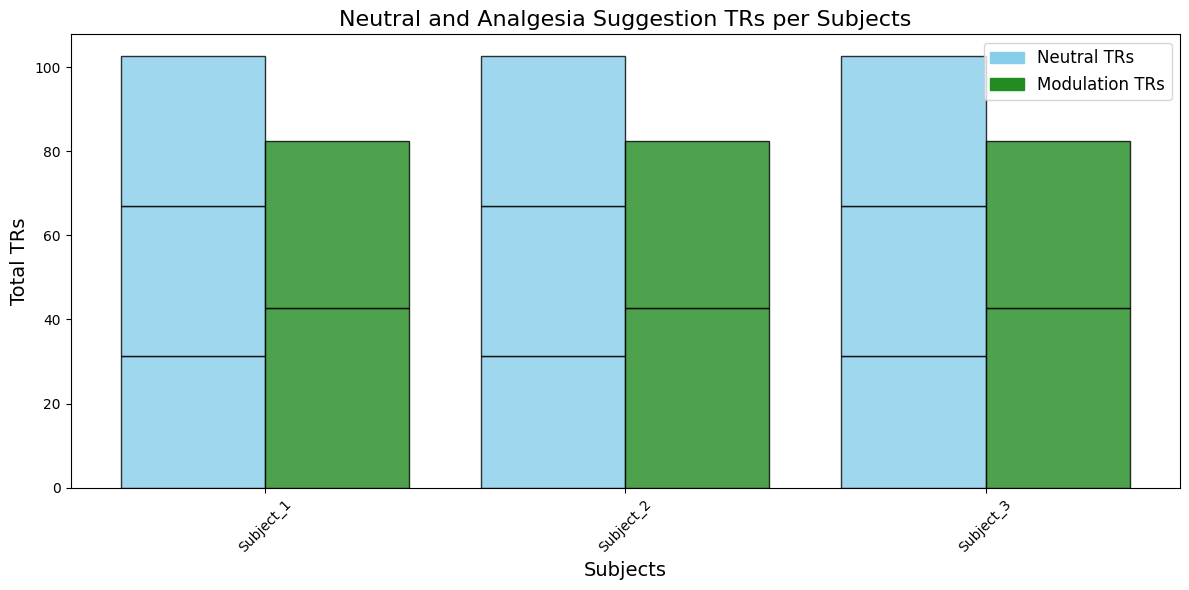

In [30]:
# saving in results/QC_TRs
save_path = os.path.join(project_dir, 'results', 'QC_TRs') 
os.makedirs(save_path, exist_ok=True)

#hyper condition
TRs_df, fig_hyper = count_TRs_2conds_general(
    events_hyper,
    TR=3,
    neutral_pattern="N_HYPER.*instrbk",
    modulation_pattern="HYPER.*instrbk",
    title='Neutral and Hyperalgesia Suggestion TRs per Subjects',
    neutral_color="skyblue",
    modulation_color="salmon",
    save_path = os.path.join(save_path, 'hyper-cond_TRs_allSubj.png')
)

plt.close(fig_hyper)

#Ana condition
TRs_df, fig_ana = count_TRs_2conds_general(
    events_ana,
    TR=3,
    neutral_pattern="N_ANA.*instrbk",
    modulation_pattern="ANA.*instrbk",
    title='Neutral and Analgesia Suggestion TRs per Subjects',
    neutral_color="skyblue",
    modulation_color="forestgreen",
    save_path = os.path.join(save_path, 'Ana-cond_TRs_allSubj.png')
)


plt.close(fig_ana)




## First level model

events_ana
events_hyper

ana_confounds
hyper_confounds

ana
hyper_filename

ana_ts_dict
hyper_ts_dict

In [111]:
# Combine the timeseries for both runs
all_run_timeseries = np.vstack([ana_timeseries, hyper_timeseries])


#### Compute and save design matrice (joint runs)
Returns dict [sub] : combined_dm

Saved design matrix for subject sub-38: CSV (sub-38-Ana-Hyper-design_matrix.csv) and PNG (sub-38-Ana-Hyper-design_matrix.png).
Saved design matrix for subject sub-07: CSV (sub-07-Ana-Hyper-design_matrix.csv) and PNG (sub-07-Ana-Hyper-design_matrix.png).
Saved design matrix for subject sub-42: CSV (sub-42-Ana-Hyper-design_matrix.csv) and PNG (sub-42-Ana-Hyper-design_matrix.png).


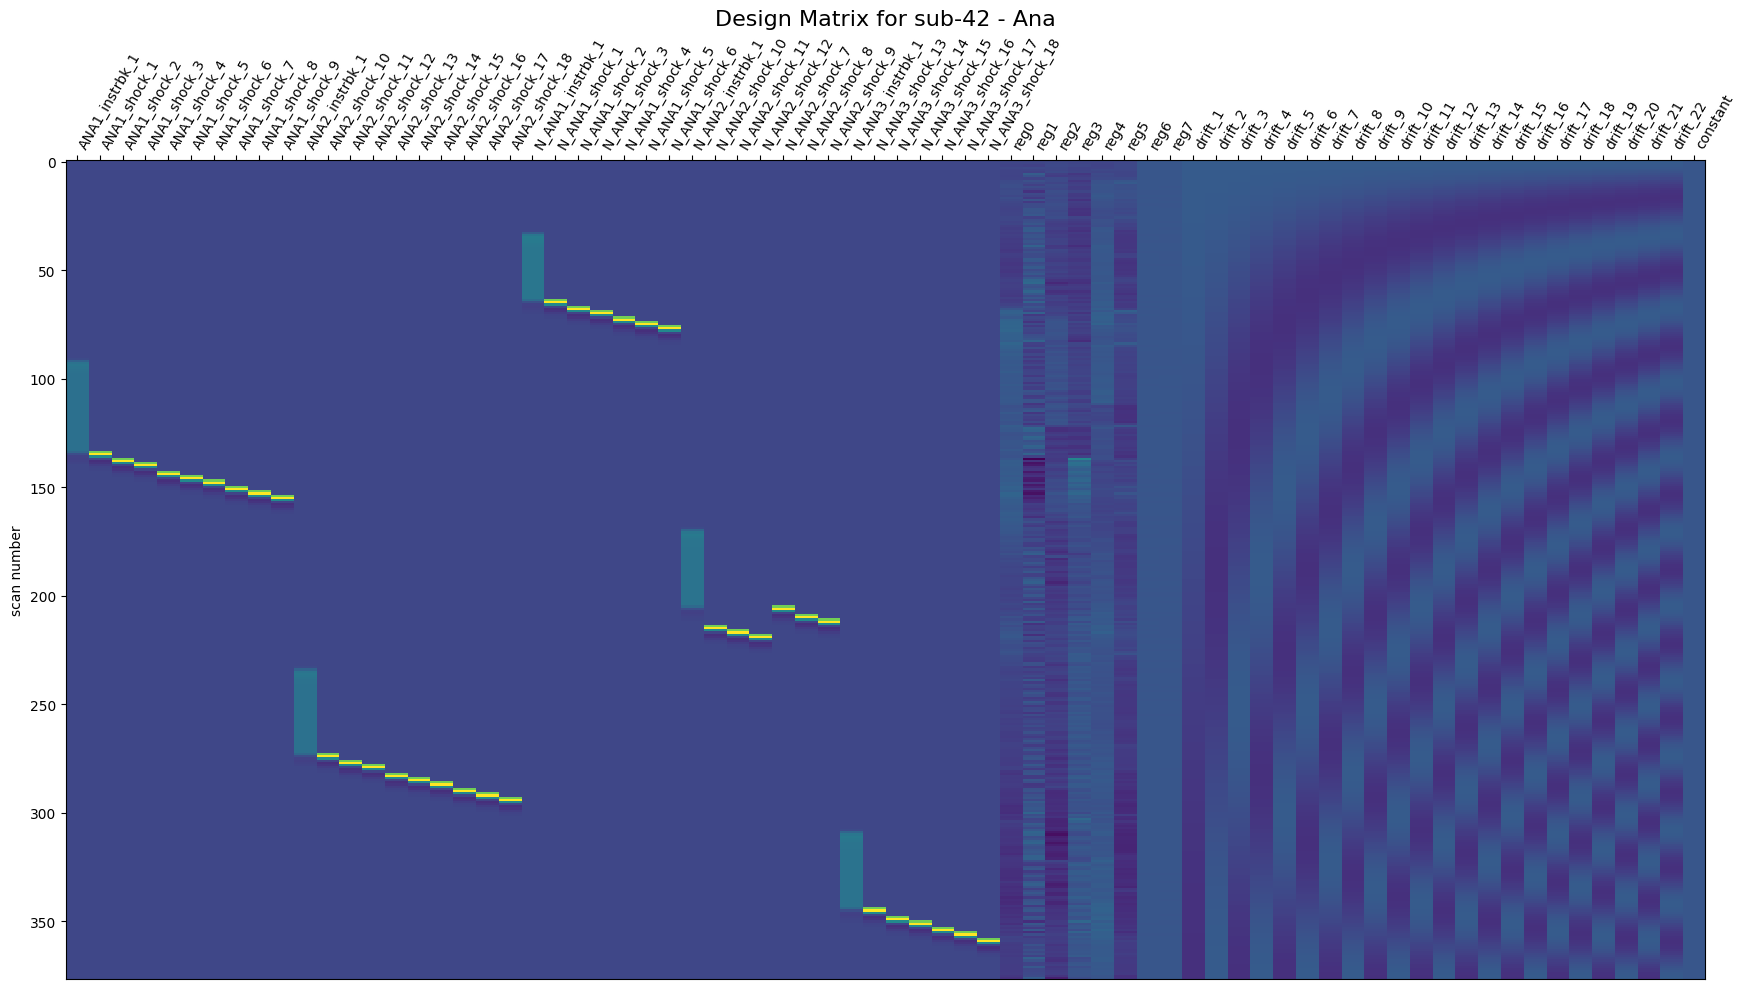

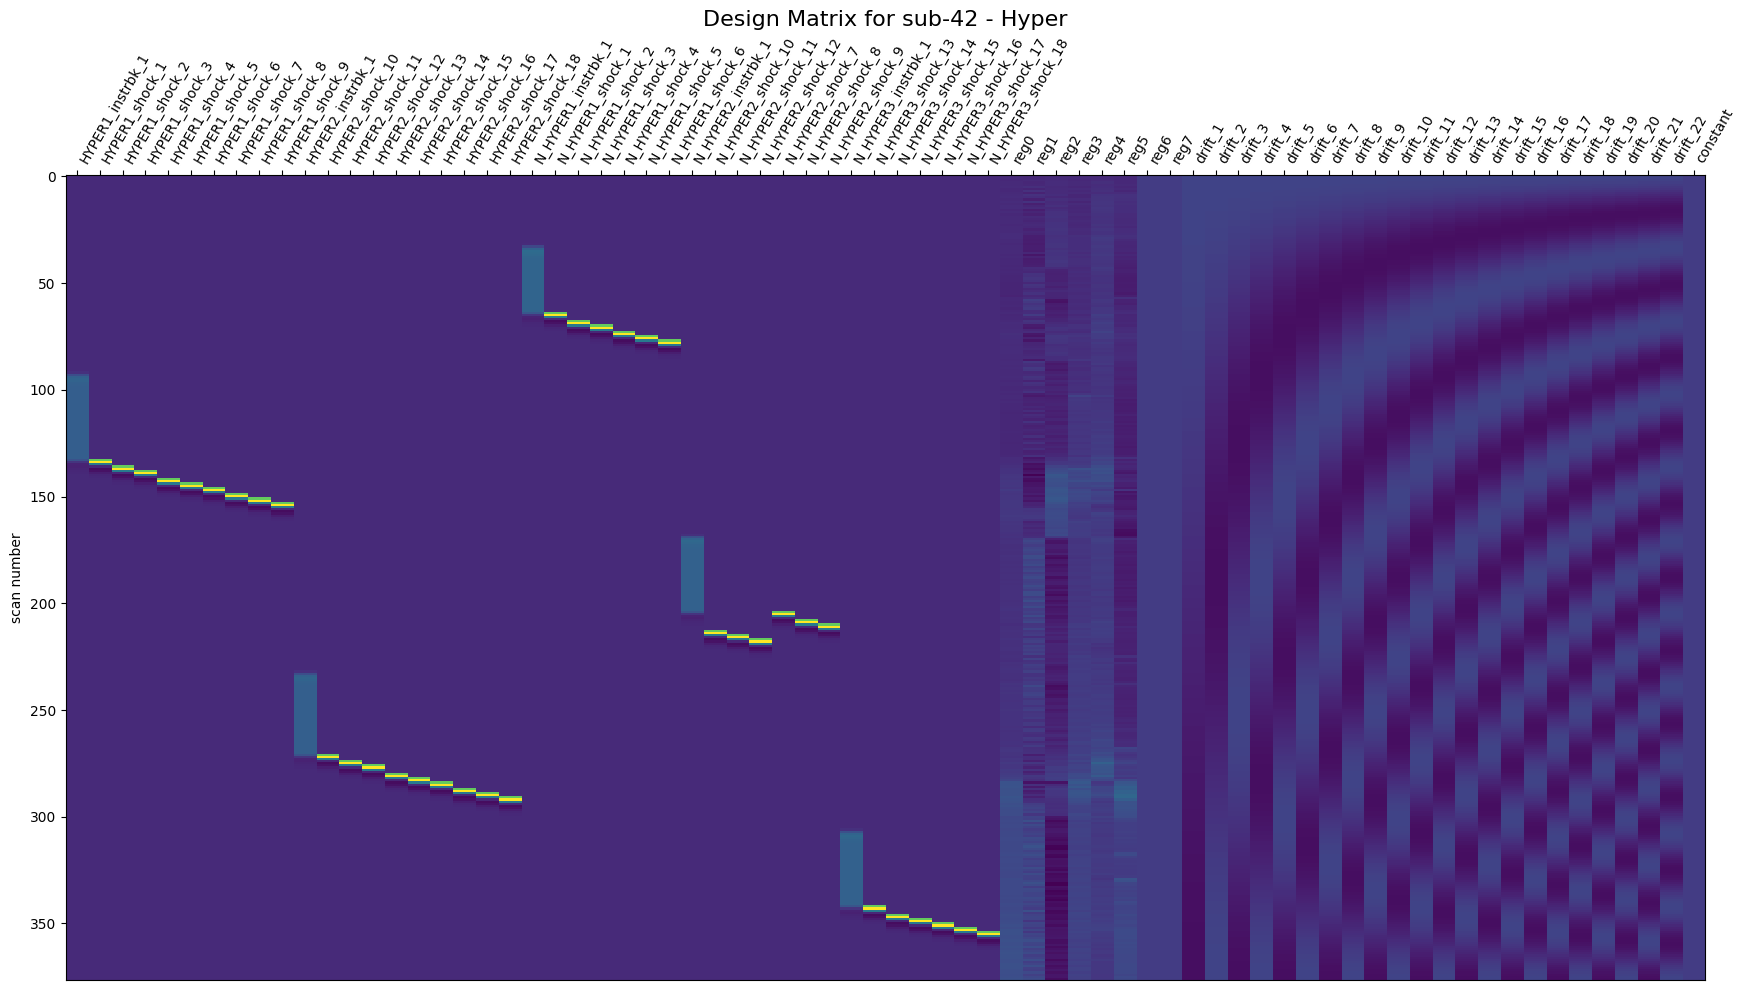

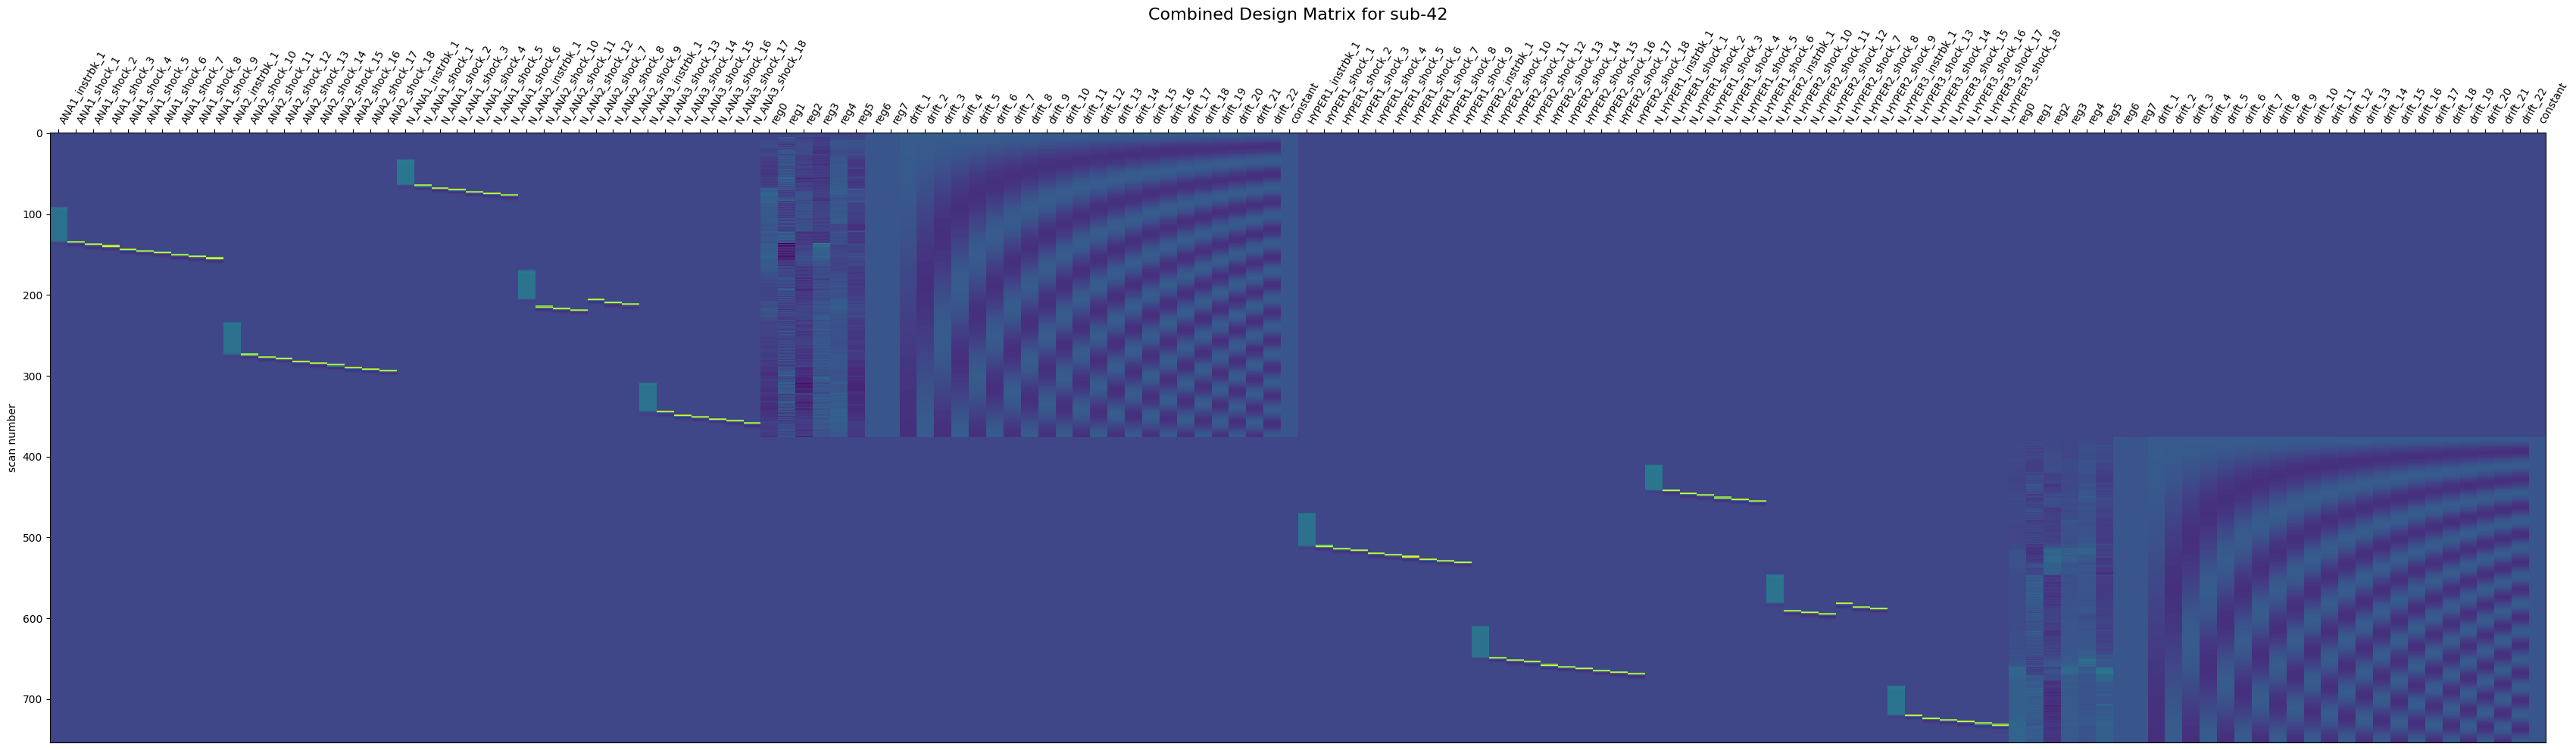

In [ ]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

# Create a dictionary to store combined design matrices for all subjects
design_matrices_2runs = {}

# Directory to save design matrices
save_path = os.path.join(project_dir, 'results', 'firstLevel', 'design_matrices')
os.makedirs(save_path, exist_ok=True)

for i, sub in enumerate(subjects):
    tr = 3
    run_names = ['Ana', 'Hyper']

    ts_ana = ana_masked_timeseries[i]
    ts_hyper = hyper_masked_timeseries[i]

    nscans = ts_ana.shape[0]
    frame_time = np.arange(nscans) * tr

    # Assert that nscans match for both runs
    assert nscans == ts_hyper.shape[0], f"Mismatch in nscans for subject {sub}"

    # Create design matrices for each run
    dm_ana = make_first_level_design_matrix(
        frame_time,
        events_ana[i],
        hrf_model='spm',
        drift_model='cosine',
        high_pass=0.01,
        add_regs=ana_confounds[i]
    )

    dm_hyper = make_first_level_design_matrix(
        frame_time,
        events_hyper[i],
        hrf_model='spm',
        drift_model='cosine',
        high_pass=0.01,
        add_regs=hyper_confounds[i]
    )

    # Combine design matrices
    zero_padding_ana = pd.DataFrame(0, index=dm_ana.index, columns=dm_hyper.columns)
    dm_ana_padded = pd.concat([dm_ana, zero_padding_ana], axis=1)

    zero_padding_hyper = pd.DataFrame(0, index=dm_hyper.index, columns=dm_ana.columns)
    dm_hyper_padded = pd.concat([zero_padding_hyper, dm_hyper], axis=1)

    dm_combined = pd.concat([dm_ana_padded, dm_hyper_padded], axis=0)
    design_matrices_2runs[sub] = dm_combined

    # Save combined design matrix as CSV
    csv_name = f'{sub}-{"-".join(run_names)}-design_matrix.csv'
    dm_combined_csv_path = os.path.join(save_path, csv_name)
    dm_combined.to_csv(dm_combined_csv_path)

    # Save combined design matrix as PNG
    png_name = f'{sub}-{"-".join(run_names)}-design_matrix.png'
    dm_combined_png_path = os.path.join(save_path, png_name)

 
    plot_design_matrix(dm_combined, rescale=True)
    plt.title(f"Combined Design Matrix for {sub}")
    plt.tight_layout()
    plt.savefig(dm_combined_png_path)
    plt.close()

    print(f"Saved design matrix for subject {sub}: CSV ({csv_name}) and PNG ({png_name}).")

    # Plot for the last subject
    if i == len(subjects) - 1:

        plot_design_matrix(dm_ana, rescale=True)
        plt.title(f"Design Matrix for {sub} - Ana", fontsize=16)
        plt.tight_layout()
        plt.show()

        plot_design_matrix(dm_hyper, rescale=True)
        plt.title(f"Design Matrix for {sub} - Hyper", fontsize=16)
        plt.tight_layout()
        plt.show()

        plot_design_matrix(dm_combined, rescale=True)
        plt.title(f"Combined Design Matrix for {sub}", fontsize=16)
        plt.tight_layout()
        plt.show()

#return design_matrices_2runs


### Extract TRs for each condition, concatenate and save
Combine the timeseries for both runs

all_run_timeseries 

design_matrices_2runs

fitted_mask_ana

fitted_mask_hyper

**new*
extracted_timeseries : list of dict, 1 key for each regressor (suggestion condition)


In [107]:
ana_masked_timeseries[0].shape

(377, 50)

In [132]:
import func
import importlib
importlib.reload(func)

#Extract TRs indices for regressors of all subjects (dict for each sub)
sugg_indices_all_reg = []

for sub in subjects:
    dm_combined = design_matrices_2runs[sub]
    print(f'==Extracting TRs indices for regressors of {sub}==')
    cond_indices = func.create_tr_masks_for_regressors(dm_combined, regressor_names=["ANA", "N_ANA", "HYPER", "N_HYPER"])
    sugg_indices_all_reg.append(cond_indices)


# Extract the timeseries for each condition
extracted_timeseries = []
cond_names = ["ANA", "N_ANA", "HYPER", "N_HYPER"]
for i, sub in enumerate(subjects):
    
    print(f"Extracted timeseries for subject {sub}: {cond_names}")
    dct_timeseries = func.extract_regressor_timeseries(all_run_timeseries, sugg_indices_all_reg[i])
    extracted_timeseries.append(dct_timeseries)

print(f"Extracted timeseries for all subjects: {cond_names}")




==Extracting TRs indices for regressors of sub-38==
Including regressors : {'ANA2_instrbk_1', 'ANA1_instrbk_1'}
Including regressors : {'N_ANA3_instrbk_1', 'N_ANA2_instrbk_1', 'N_ANA1_instrbk_1'}
Including regressors : {'HYPER2_instrbk_1', 'HYPER1_instrbk_1'}
Including regressors : {'N_HYPER2_instrbk_1', 'N_HYPER3_instrbk_1', 'N_HYPER1_instrbk_1'}
Conditions 'dict_keys(['ANA', 'N_ANA', 'HYPER', 'N_HYPER'])' have  [87, 110, 84, 110] TRs.
==Extracting TRs indices for regressors of sub-07==
Including regressors : {'ANA2_instrbk_1', 'ANA1_instrbk_1'}
Including regressors : {'N_ANA3_instrbk_1', 'N_ANA2_instrbk_1', 'N_ANA1_instrbk_1'}
Including regressors : {'HYPER2_instrbk_1', 'HYPER1_instrbk_1'}
Including regressors : {'N_HYPER2_instrbk_1', 'N_HYPER3_instrbk_1', 'N_HYPER1_instrbk_1'}
Conditions 'dict_keys(['ANA', 'N_ANA', 'HYPER', 'N_HYPER'])' have  [87, 110, 84, 110] TRs.
==Extracting TRs indices for regressors of sub-42==
Including regressors : {'ANA2_instrbk_1', 'ANA1_instrbk_1'}
Includ

#### To do : 
save concatenated timeseries for each condition

! make sure that the masker use for inverse is the proper on (ana or hyper run)
```
import os

save_dir = os.path.join(project_dir, 'results', 'extracted_conditions')
os.makedirs(save_dir, exist_ok=True)

for sub, condition_data in all_extracted_timeseries.items():
    print(f"Saving extracted timeseries for subject {sub}...")
    subject_dir = os.path.join(save_dir, sub)
    os.makedirs(subject_dir, exist_ok=True)
    
    for condition, timeseries in condition_data.items():
        # Inverse transform to 4D NIfTI image
        masker = fitted_mask_ana[sub]  # Adjust if the masker is stored differently
        nifti_image = masker.inverse_transform(timeseries)

        # Save the NIfTI file
        save_path = os.path.join(subject_dir, f"{condition}.nii.gz")
        nifti_image.to_filename(save_path)
        print(f"Saved {condition} timeseries for {sub} to {save_path}.")

```

In [ ]:
import func
import importlib
importlib.reload(func)

#Extract TRs indices for regressors of all subjects (dict for each sub)
sugg_indices_all_reg = []

for sub in subjects:
    dm_combined = design_matrices_2runs[sub]
    print(f'==Extracting TRs indices for regressors of {sub}==')
    cond_indices = func.create_tr_masks_for_regressors(dm_combined, regressor_names=["ANA", "N_ANA", "HYPER", "N_HYPER"])
    sugg_indices_all_reg.append(cond_indices)


# Extract the timeseries for each condition
extracted_timeseries = []
cond_names = ["ANA", "N_ANA", "HYPER", "N_HYPER"]
for i, sub in enumerate(subjects):
    
    print(f"Extracted timeseries for subject {sub}: {cond_names}")
    dct_timeseries = func.extract_regressor_timeseries(all_run_timeseries, sugg_indices_all_reg[i])
    extracted_timeseries.append(dct_timeseries)

print(f"Extracted timeseries for all subjects: {cond_names}")




==Extracting TRs indices for regressors of sub-38==
Including regressors : {'ANA2_instrbk_1', 'ANA1_instrbk_1'}
Including regressors : {'N_ANA3_instrbk_1', 'N_ANA2_instrbk_1', 'N_ANA1_instrbk_1'}
Including regressors : {'HYPER2_instrbk_1', 'HYPER1_instrbk_1'}
Including regressors : {'N_HYPER2_instrbk_1', 'N_HYPER3_instrbk_1', 'N_HYPER1_instrbk_1'}
Conditions 'dict_keys(['ANA', 'N_ANA', 'HYPER', 'N_HYPER'])' have  [87, 110, 84, 110] TRs.
==Extracting TRs indices for regressors of sub-07==
Including regressors : {'ANA2_instrbk_1', 'ANA1_instrbk_1'}
Including regressors : {'N_ANA3_instrbk_1', 'N_ANA2_instrbk_1', 'N_ANA1_instrbk_1'}
Including regressors : {'HYPER2_instrbk_1', 'HYPER1_instrbk_1'}
Including regressors : {'N_HYPER2_instrbk_1', 'N_HYPER3_instrbk_1', 'N_HYPER1_instrbk_1'}
Conditions 'dict_keys(['ANA', 'N_ANA', 'HYPER', 'N_HYPER'])' have  [87, 110, 84, 110] TRs.
==Extracting TRs indices for regressors of sub-42==
Including regressors : {'ANA2_instrbk_1', 'ANA1_instrbk_1'}
Includ

In [124]:
dct_timeseries['N_ANA'].shape

(110, 50)

In [110]:
sugg_indices


{'ANA': array([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 233, 234, 235, 236, 237, 238, 239,
        240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
        253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
        266, 267, 268, 269, 270, 271, 272, 273, 274]),
 'N_ANA': array([ 32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  63,  64,  65, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
        187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
        200, 201, 202, 203, 204, 205, 206, 308, 309, 310, 311, 312, 313,
        314, 315, 316, 317, 318, 319, 320, 321, 322, 

In [65]:
# extract TRs for each condition
condition_keys = ['ANA', 'N_ANA', 'HYPER', 'N_HYPER']
condition = 'N_ANA'


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import numpy as np

def create_design_matrix(events, confounds_file, TR, n_scans, title):
    """
    Create and plot a design matrix for one run.

    Parameters:
    -----------
    events : pd.DataFrame
        DataFrame containing onset, duration, and trial_type columns for the run.

    confounds_file : str
        Path to the confounds file for the run.

    TR : int
        Repetition time (TR) in seconds.

    n_scans : int
        Number of scans in the fMRI run.

    title : str
        Title for the design matrix plot.

    Returns:
    --------
    design_matrix : pd.DataFrame
        The design matrix for the run.

    fig : matplotlib.figure.Figure
        The figure object of the design matrix plot.
    """
    # Frame times for each TR
    frame_times = np.arange(n_scans) * TR


    # Create the design matrix
    design_matrix = make_first_level_design_matrix(
        frame_times=frame_times,
        events=events,
        add_regs=confounds.values,
        add_reg_names=confounds.columns
    )

    # Plot the design matrix
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_design_matrix(design_matrix, ax=ax)
    ax.set_title(title)
    plt.tight_layout()

    return design_matrix, fig


# Parameters for one subject
TR = 3  # Adjust based on your fMRI TR
n_scans_hyper = 200  # Adjust based on the number of scans in the hyper run
n_scans_ana = 180  # Adjust based on the number of scans in the analgesia run

subject_index = 0  # Replace with the desired subject index

# Paths to confounds
confounds_hyper = hyper_run[subject_index]
confounds_ana = ana_run[subject_index]

# Events for hyper and analgesia runs
events_hyper_subject = events_hyper[subject_index]
events_ana_subject = events_ana[subject_index]

# Create and plot the design matrix for the hyper run
dm_hyper, fig_hyper = create_design_matrix(
    events_hyper_subject,
    confounds_hyper,
    TR,
    n_scans_hyper,
    "Design Matrix for Hyper Run"
)

# Create and plot the design matrix for the analgesia run
dm_ana, fig_ana = create_design_matrix(
    events_ana_subject,
    confounds_ana,
    TR,
    n_scans_ana,
    "Design Matrix for Analgesia Run"
)

# Save figures
fig_hyper.savefig(f"design_matrix_hyper_subject_{subject_index + 1}.png", dpi=300)
fig_ana.savefig(f"design_matrix_ana_subject_{subject_index + 1}.png", dpi=300)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 78: invalid start byte

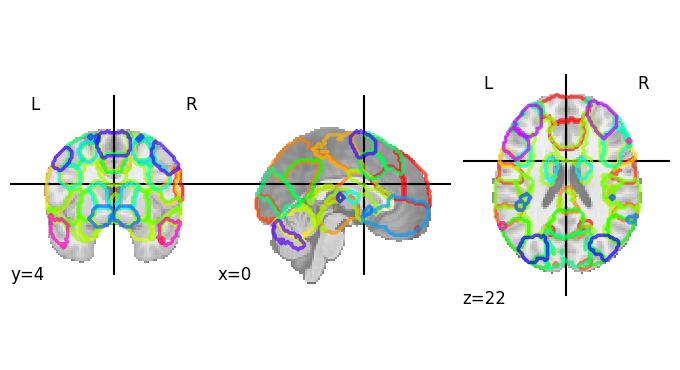

In [34]:
from nilearn.plotting import plot_prob_atlas

mask_nifti = mask_x.to_nifti()
view = plot_prob_atlas(mask_nifti, threshold=None)  # Use threshold=None to display the whole mask
view

**Extract data in ROI**

In [8]:
#func_ana = Brain_Data(ana_files)
n_subj = 6; # limit computation time

roi = 4
roi_mask = mask_x[roi]

#file_list = glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', f'*crop*{scan}*nii.gz'))
ana_data = []
for count, (sub, f) in enumerate(zip(subjects, ana_files)):
    if count > n_subj:
        break
    else:    
        print(sub)
        data = Brain_Data(f)
        ana_data.append(data.apply_mask(roi_mask))

sub-09
sub-03
sub-22
sub-28
sub-17
sub-41
sub-36


**Hyper align**

In [11]:
ana_data

[nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(372, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)]

In [12]:
hyperalign = align(ana_data[:6], method='procrustes')

In [34]:
hyperalign

{'transformed': [nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz)],
 'common_model': nltools.data.brain_data.Brain_Data(data=(377, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
 'transformation_matrix': [nltools.data.brain_data.Brain_Data(data=(2786, 2786), Y=(0, 0), X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz),
  nltools.data.brain_data.Brain

Text(0.5, 1.0, 'Aligned Voxel ISC: r=0.3')

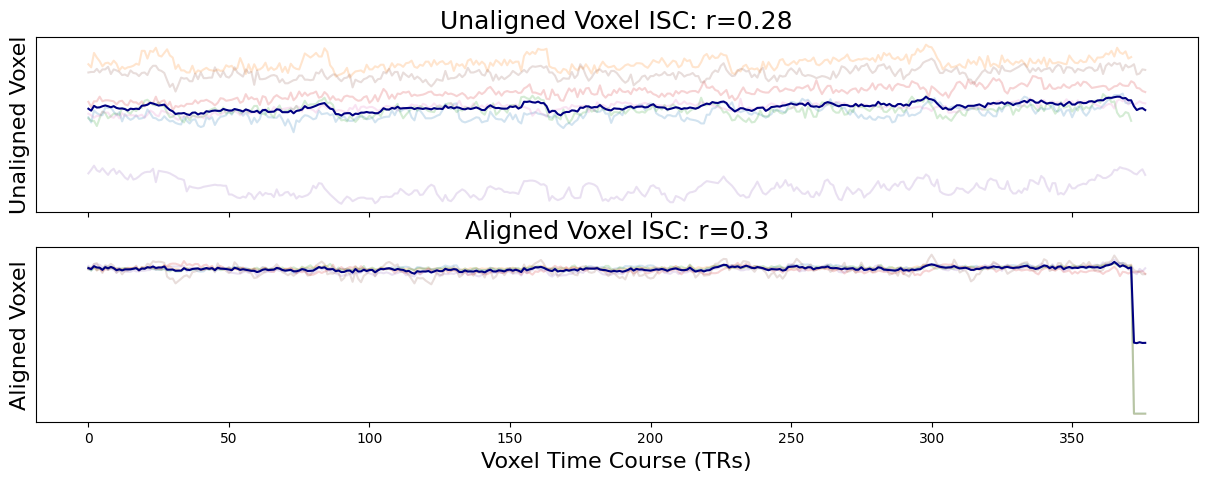

In [17]:
voxel_index = 50

voxel_unaligned = pd.DataFrame([x.data[:, voxel_index] for x in ana_data]).T # x is subject i
voxel_aligned = pd.DataFrame([x.data[:, voxel_index] for x in hyperalign['transformed']]).T

f, a = plt.subplots(nrows=2, figsize=(15, 5), sharex=True)
a[0].plot(voxel_unaligned, linestyle='-', alpha=.2)
a[0].plot(np.mean(voxel_unaligned, axis=1), linestyle='-', color='navy')
a[0].set_ylabel('Unaligned Voxel', fontsize=16)
a[0].yaxis.set_ticks([])

a[1].plot(voxel_aligned, linestyle='-', alpha=.2)
a[1].plot(np.mean(voxel_aligned, axis=1), linestyle='-', color='navy')
a[1].set_ylabel('Aligned Voxel', fontsize=16)
a[1].yaxis.set_ticks([])

plt.xlabel('Voxel Time Course (TRs)', fontsize=16)
a[0].set_title(f"Unaligned Voxel ISC: r={Adjacency(voxel_unaligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)
a[1].set_title(f"Aligned Voxel ISC: r={Adjacency(voxel_aligned.corr(), matrix_type='similarity').mean():.02}", fontsize=18)


**ISC distribution : N voxel pair-wise correlation, meaned**

Unaligned voxel ISC

In [22]:
ana_data[0].data.flatten().shape

(1036392,)

In [23]:
ana_data[0].data.shape[1]

2786

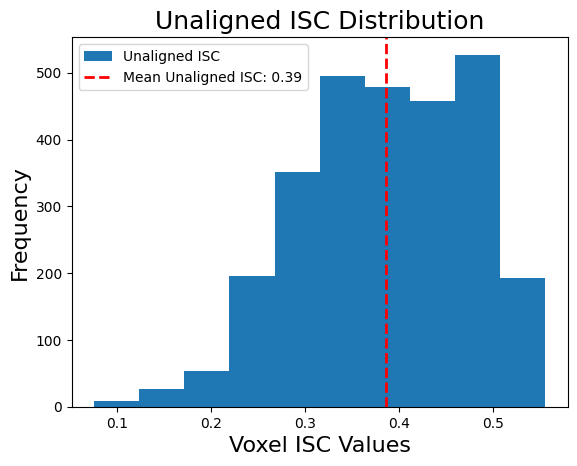

Mean Unaligned ISC (voxel-wise): 0.39


In [30]:
import numpy as np
from nltools.data import Adjacency

unaligned_isc = {}

#compute mean ISC for each unaligned voxel to plot distribution
for voxel_index in range(ana_data[0].data.shape[1]):  # Assuming all_data is a list of Brain_Data objects
    # Extract the time series for this voxel across all subjects
    voxel_time_series = np.array([x.data[:372, voxel_index] for x in ana_data])  # shape (n_subjects, n_timepoints)
    voxel_corr = np.corrcoef(voxel_time_series)  # matrix shape (n_subjects, n_subjects)
    triu_indices = np.triu_indices_from(voxel_corr, k=1) # mean of triangle
    unaligned_isc[voxel_index] = voxel_corr[triu_indices].mean()

plt.hist(unaligned_isc.values(),label='Unaligned ISC')
plt.axvline(x=np.mean(list(unaligned_isc.values())), linestyle='--', color='red', linewidth=2, label=f'Mean Unaligned ISC: {np.mean(list(unaligned_isc.values())):.2f}')
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.title('Unaligned ISC Distribution', fontsize=18)
plt.legend()
plt.show()

# Print the mean ISC value for unaligned data
print(f"Mean Unaligned ISC (voxel-wise): {np.mean(list(unaligned_isc.values())):.2f}")


Mean ISC: 0.33


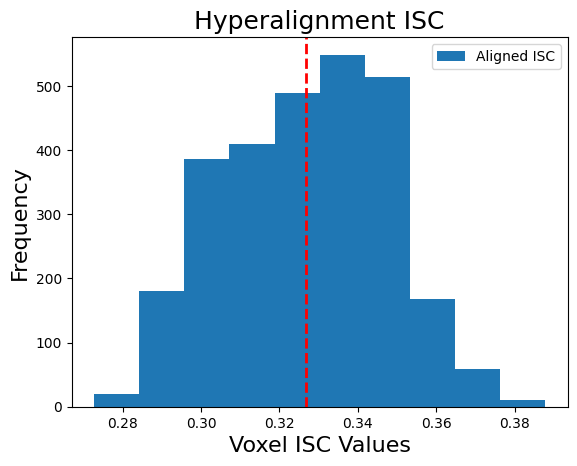

In [32]:
plt.hist(hyperalign['isc'].values(), label='Aligned ISC')
plt.axvline(x=np.mean(list(hyperalign['isc'].values())), linestyle='--', color='red', linewidth=2)
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Voxel ISC Values', fontsize=16)
plt.legend()
plt.title('Hyperalignment ISC', fontsize=18)

print(f"Mean ISC: {np.mean(list(hyperalign['isc'].values())):.2}")

**Compare a slice of ROI**

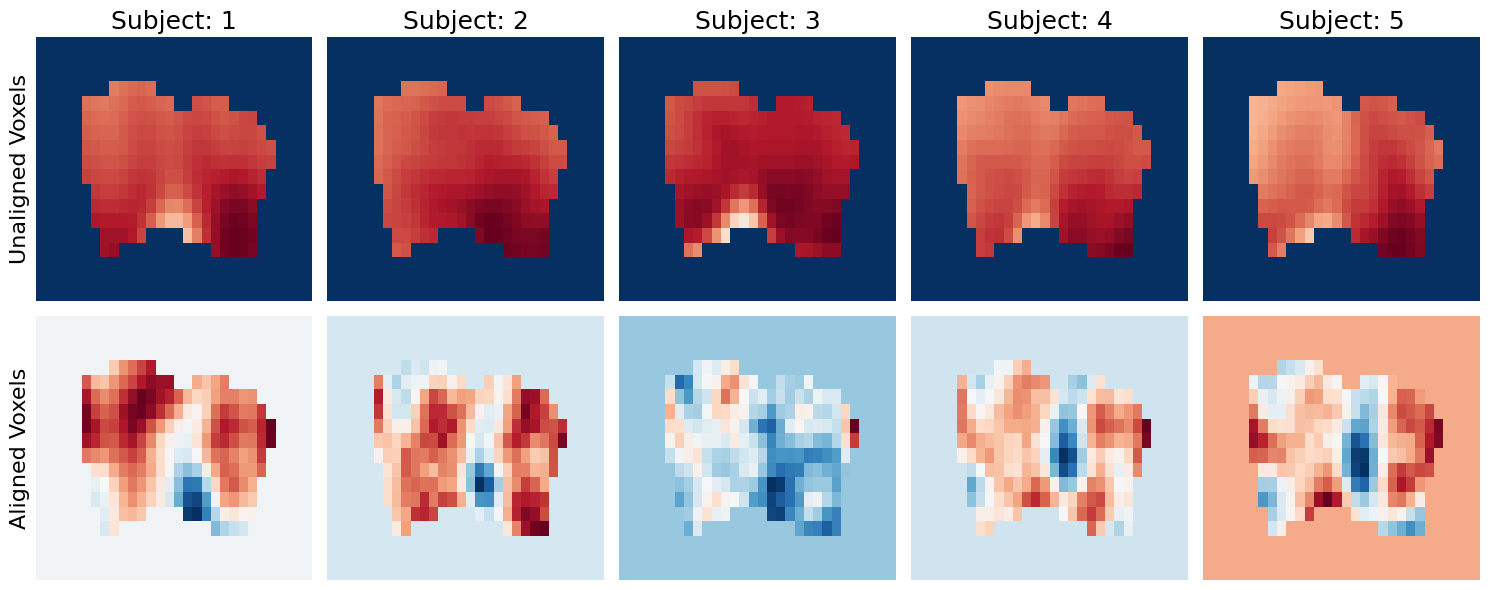

In [33]:
tr_index = 100

f,a = plt.subplots(ncols=5, nrows=2, figsize=(15,6), sharex=True, sharey=True)
for i in range(5):
    sns.heatmap(np.rot90(ana_data[i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[0,i])
    a[0,i].set_title(f'Subject: {i+1}', fontsize=18)
    a[0,i].axes.get_xaxis().set_visible(False)
    a[0,i].yaxis.set_ticks([])
    sns.heatmap(np.rot90(hyperalign['transformed'][i][tr_index].to_nifti().dataobj[30:60, 10:28, 37]), cbar=False, cmap='RdBu_r', ax=a[1,i])
    a[1,i].axes.get_xaxis().set_visible(False)
    a[1,i].yaxis.set_ticks([])

a[0,0].set_ylabel('Unaligned Voxels', fontsize=16)
a[1,0].set_ylabel('Aligned Voxels', fontsize=16)

plt.tight_layout()

In [ ]:
data_dir = '/data/rainville/Hypnosis_ISC/4D_data/segmented'